In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage import color
import gc
import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as T

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# for training with HSV channels
def rgb2hsv(img):
    # img - image tensor
    img_original = img.numpy().transpose((1, 2, 0))
    img_hsv = color.rgb2hsv(img_original)
    img_hs = img_hsv[:, :, 0:2]
    img_hs = torch.from_numpy(img_hs.transpose((2, 0, 1))).float()
    img_v = img_hsv[:, :, 2]
    img_v = torch.from_numpy(img_v).float().unsqueeze(0)
    img_gray = color.rgb2gray(img_original)
    img_gray = torch.from_numpy(img_gray).unsqueeze(0).float()
    return img_gray, img_hs, img_v

def hsv2rgb(v, h, s):
    # l, a, b - image tensors representing LAB channels
    img_hsv = torch.stack([h, s, v])
    img_rgb = color.hsv2rgb(img_hsv.cpu().detach().numpy().transpose((1, 2, 0)))
    img_rgb = torch.from_numpy(img_rgb.transpose((2, 0, 1))).float()
    return img_rgb

# for training with LAB channels

def rgb2lab(img):
    # img - image tensor
    img_original = img.numpy().transpose((1, 2, 0))
    img_lab = color.rgb2lab(img_original)
    img_lab = (img_lab + 128) / 255
    img_ab = img_lab[:, :, 1:3]
    img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
    img_l = img_lab[:, :, 0]
    img_l = torch.from_numpy(img_l).float().unsqueeze(0)
    img_gray = color.rgb2gray(img_original)
    img_gray = torch.from_numpy(img_gray).unsqueeze(0).float()
    return img_gray, img_ab, img_l

def lab2rgb(l, a, b):
    # l, a, b - image tensors representing LAB channels
    img_lab = torch.stack([l, a, b])
    img_lab = img_lab * 255 - 128
    img_rgb = color.lab2rgb(img_lab.cpu().detach().numpy().transpose((1, 2, 0)))
    img_rgb = torch.from_numpy(img_rgb.transpose((2, 0, 1))).float()
    return img_rgb

/homes/iws/lpremc/miniconda3/envs/cse455/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# global feature extractor based on Resnet152
class ExtractorResnet152(nn.Module):
    def __init__(self):
        super(ExtractorResnet152, self).__init__()
        model = torchvision.models.resnet152()
        model.conv1.weight = nn.Parameter(model.conv1.weight.sum(dim=1).unsqueeze(1))
        self.layers = nn.Sequential(
            *list(model.children())[0:6]
        )

    def forward(self, x):
        x = self.layers(x)
        return x

# auto encoder decoder based on Resnet18
class ColorNetResnet18(nn.Module):

    def __init__(self, mid_input_size=0):
        super(ColorNetResnet18, self).__init__()
        self.mid_input_size = mid_input_size
        resnet = torchvision.models.resnet18()
        resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1))
        self.encoder = nn.Sequential(*list(resnet.children())[0:6])
        self.decoder = nn.Sequential(     
            nn.Conv2d(mid_input_size + 128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
            nn.Upsample(scale_factor=2)
        )

    def forward(self, x, in_=None):
        x = self.encoder(x)
        if self.mid_input_size > 0:
            x = torch.cat([x, in_], dim=1)
        x = self.decoder(x)
        return x

# auto encoder decoder based on Resnet18
class ColorNetResnet50(nn.Module):

    def __init__(self, mid_input_size=0):
        super(ColorNetResnet50, self).__init__()
        self.mid_input_size = mid_input_size
        resnet = torchvision.models.resnet50()
        resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1))
        self.encoder = nn.Sequential(*list(resnet.children())[0:6])
        encoder_output_size = self.encoder(torch.zeros((1, 1, 256, 256))).shape[1]
        
        self.decoder = nn.Sequential(     
            nn.Conv2d(mid_input_size + encoder_output_size, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
            nn.Upsample(scale_factor=2)
        )

    def forward(self, x, in_=None):
        x = self.encoder(x)
        if self.mid_input_size > 0:
            x = torch.cat([x, in_], dim=1)
        x = self.decoder(x)
        return x

In [4]:
models = {
    "resnet18": ColorNetResnet18,
    "resnet50": ColorNetResnet50
}
extractors = {
    "resnet152": ExtractorResnet152
}
model_name = "resnet50"
extractor = ExtractorResnet152()
model = models[model_name](mid_input_size=extractor(torch.zeros((1, 1, 256, 256))).shape[1])
model.load_state_dict(torch.load('models/resnet50_2022-05-23_21:01:04:498923.pth'))
extractor.to(device)
model.to(device)

ColorNetResnet50(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Co

In [5]:
def get_datasets(dataset_path):
    dataset = torchvision.datasets.ImageFolder(dataset_path, transform=T.Compose([
        T.Resize((256, 256)),
        T.ToTensor()
    ]))

    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    return torch.utils.data.random_split(dataset, [train_size, test_size])
lhq256_train, lhq256_test = get_datasets("LHQ256")

In [6]:
time = str(datetime.datetime.now()).replace('.', ':').replace(' ', '_')
color_mode = 'lab'
checkpoint_path = f'models/{model_name}_{color_mode}_{time}.pth'
convert_fn = rgb2lab
revert_fn = lab2rgb
if color_mode == 'hsv':
  convert_fn = rgb2hsv
  revert_fn = hsv2rgb

def train(model, extractor, train_dataset, plot_name, convert_fn, num_batches=10, batch_size=16, epochs=100, lr=0.1, decay=1e-10):
  losses = []
  criterion = nn.MSELoss().to(device)
  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
  min_loss = 10000
  with tqdm(range(epochs)) as eps:
    total_loss = 0
    for e in eps:
      # train for num_batches batches per epoch
      try:
        # sample an image batch
        batch_idx = random.choices(np.arange(len(train_dataset)), k=batch_size)
        train_images = [convert_fn(train_dataset[n][0]) for n in batch_idx]
        gray_inputs = torch.stack([im[0] for im in train_images]).to(device)
        color_inputs = torch.stack([im[1] for im in train_images]).to(device)
      except:
        continue
      
      # backpropagate and step
      optimizer.zero_grad()
      global_features = extractor(gray_inputs).to(device)
      color_outputs = model(gray_inputs, global_features).to(device)
      loss = criterion(color_outputs, color_inputs)
      loss.backward()
      optimizer.step()

      # clear memory
      del gray_inputs
      del color_inputs
      del global_features
      del color_outputs
      gc.collect()
      torch.cuda.empty_cache()
      total_loss += loss.item().real

      # plot losses
      if (e % num_batches == 0 and e != 0):
        # mean loss per epoch
        mean_loss = total_loss / num_batches
        eps.set_postfix(loss=mean_loss)

        # save model if perform better
        if (mean_loss < min_loss):
          min_loss = mean_loss
          torch.save(model.state_dict(), checkpoint_path)
        losses.append(mean_loss)
        total_loss = 0
        plt.figure()
        plt.plot(losses)
        plt.yscale('log')
        plt.xlabel("iterations")
        plt.ylabel("loss")
        plt.savefig(plot_name)
        plt.close('all')

In [7]:
train(model, extractor, lhq256_train, convert_fn=rgb2lab, num_batches=5, batch_size=16, epochs=2000, lr=0.01, plot_name=f"plots/{model_name}_{color_mode}_losses_{time}.png")

 37%|███▋      | 746/2000 [16:50<28:17,  1.35s/it, loss=0.00326] 


KeyboardInterrupt: 

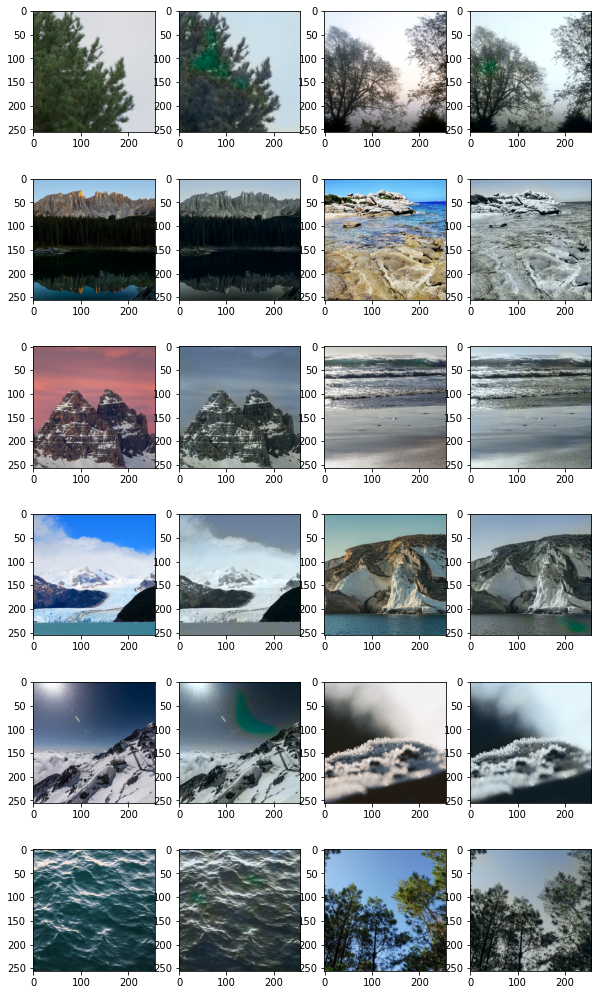

In [13]:
# try predict colors
pil_image = T.ToPILImage()
convert_fn = rgb2lab
revert_fn = lab2rgb
dataset = lhq256_test
batch_idx = random.choices(range(len(dataset)), k=12)
test_images = [convert_fn(dataset[n][0]) for n in batch_idx]
gray_inputs = torch.stack([im[0] for im in test_images]).to(device)
color_inputs = torch.stack([im[1] for im in test_images]).to(device)
l_inputs = torch.stack([im[2] for im in test_images]).to(device)
global_features = extractor(gray_inputs)
color_outputs = model(gray_inputs, global_features)
rgb_inputs = torch.stack([dataset[n][0] for n in batch_idx])
rgb_outputs = torch.stack([revert_fn(l_inputs[i][0], color_outputs[i][0], color_outputs[i][1]) for i in range(len(color_outputs))])
plt.figure(figsize=(10, 18))
nrows = int(len(rgb_outputs) / 2)
ncols = 4
for i in range(nrows):
    plt.subplot(nrows, ncols, i*ncols+1)
    plt.imshow(pil_image(rgb_inputs[i*2]))
    plt.subplot(nrows, ncols, i*ncols+2)
    plt.imshow(pil_image(rgb_outputs[i*2]))
    plt.subplot(nrows, ncols, i*ncols+3)
    plt.imshow(pil_image(rgb_inputs[i*2+1]))
    plt.subplot(nrows, ncols, i*ncols+4)
    plt.imshow(pil_image(rgb_outputs[i*2+1]))
plt.savefig(f"results_{model_name}_result.png")

In [9]:
torch.cuda.empty_cache()

In [8]:
resnet = torchvision.models.resnet50()
resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1))
encoder = nn.Sequential(*list(resnet.children())[0:6])
encoder(torch.zeros((1, 1, 256, 256))).shape[1]

512

In [6]:
encoder(torch.zeros((1, 1, 256, 256))).shape[1]

128